# CS 6140 Machine Learning: Final Group Project
## Philip Butler, Riley Grant, Benjamin Ruzzo

words words words

In [1]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("./data/CountyState_Alc_Cig_HDDeath.csv")
df.head()

,county_state,2012 Both Sexes,cig_total_mean,cig_daily_mean,deaths-per-100k
0,"Abbeville, SC",41.3,25.39,18.09,989.3
1,"Acadia, LA",48.7,30.57,23.93,1407.6
2,"Accomack, VA",48.1,22.99,16.62,1275.2
3,"Ada, ID",59.6,16.62,12.43,1004.3
4,"Adair, IA",55.8,22.35,16.80,888.0


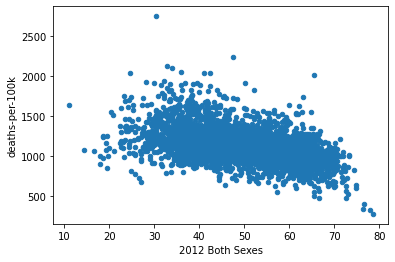

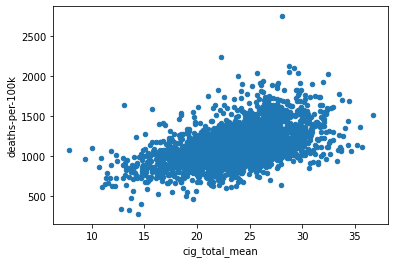

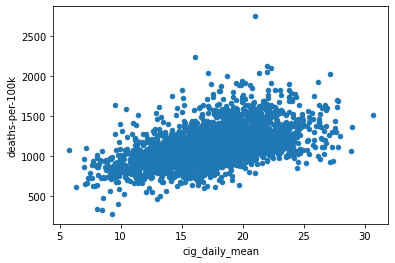

In [2]:
# Plot all features against deaths-per-100k - Ignores first and last columns of df (county_state and deaths-per-100k)
for col in df.columns[1:-1]:
    df.plot.scatter(x=col, y='deaths-per-100k')

In [3]:
full_data = pd.read_csv('.\data\data_all_features.csv')
full_data.head()

,county_state,hyp_total_2009,cig_total_2012,cig_daily_2012,obs_total_2006,dbt_total_2012,alc_any_2008,alc_heavy_2008,alc_binge_2008,hd_deaths_per100k_over65
0,"Autauga, AL",38.87,25.10,18.41,67.26,11.44,41.2,6.0,13.1,1292.6
1,"Baldwin, AL",36.79,20.90,16.02,76.59,9.76,55.1,9.1,17.7,1182.2
2,"Barbour, AL",47.63,26.25,18.73,59.95,14.65,37.0,5.6,12.0,1508.6
3,"Bibb, AL",43.28,29.41,22.62,59.95,12.32,34.2,5.2,11.6,1362.3
4,"Blount, AL",40.80,27.17,19.88,62.09,11.14,34.1,4.8,10.8,1327.2


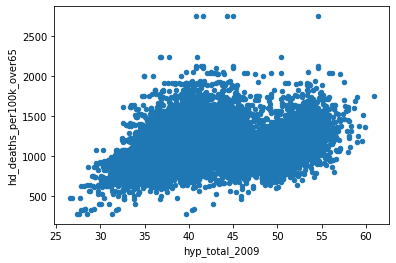

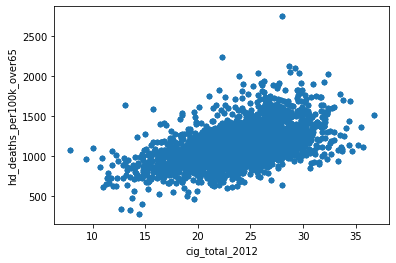

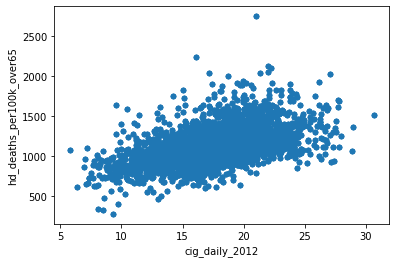

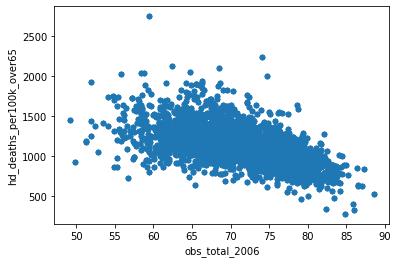

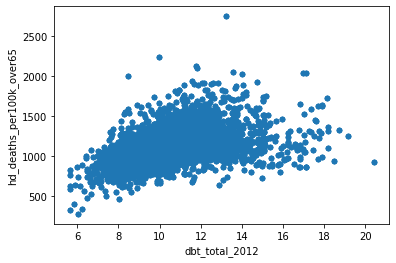

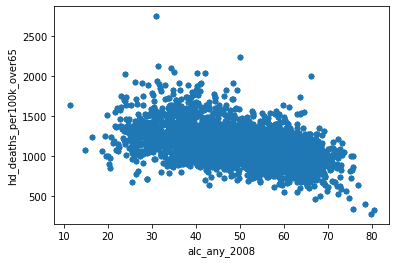

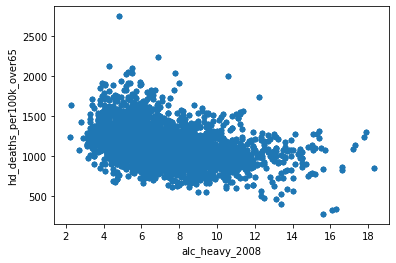

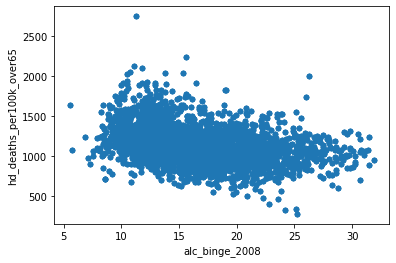

In [4]:
#All features for full data set plotted against hd_deaths_per100k_over65
for col in full_data.columns[1:-1]:
    full_data.plot.scatter(x=col, y='hd_deaths_per100k_over65')

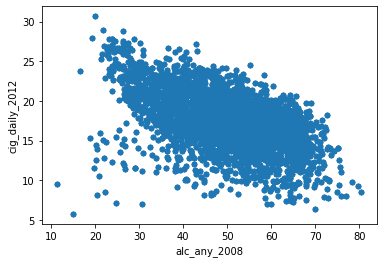

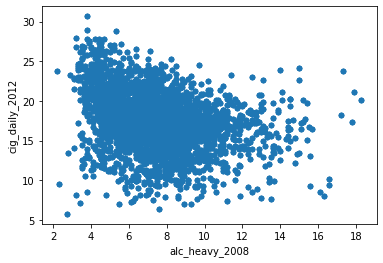

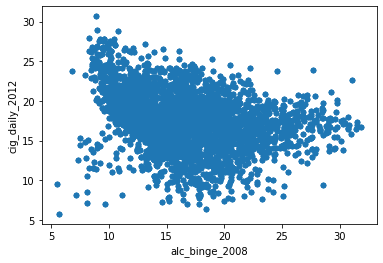

In [5]:
#All alcohol versus cig_total
for col in full_data.columns[6:9]:
    full_data.plot.scatter(x=col ,y='cig_daily_2012')

<AxesSubplot:>

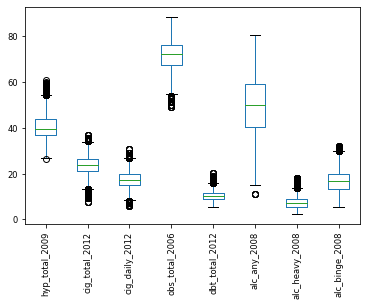

In [6]:
#Boxplots of all features but location
data_features = full_data.drop(['county_state','hd_deaths_per100k_over65'],axis = 1)

data_features.boxplot(grid=False,fontsize='small',rot=90)

<AxesSubplot:>

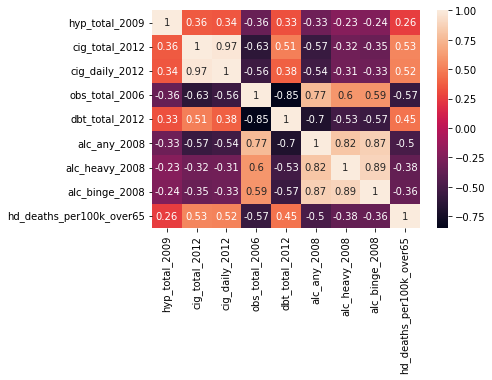

In [7]:
#Heatmap for feature correlation
full_data = full_data.drop(['county_state'],axis=1)
sbn.heatmap(full_data.corr(),annot=True)

<AxesSubplot:>

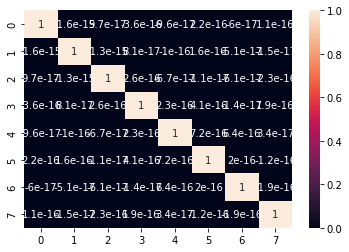

In [8]:
from sklearn.decomposition import PCA
#PCA transformation down to two dimensions and then correlation heatmap
pca = PCA(8)
transformed = pca.fit_transform(data_features)
pca_data = pd.DataFrame(transformed)
sbn.heatmap(pca_data.corr(),annot=True)

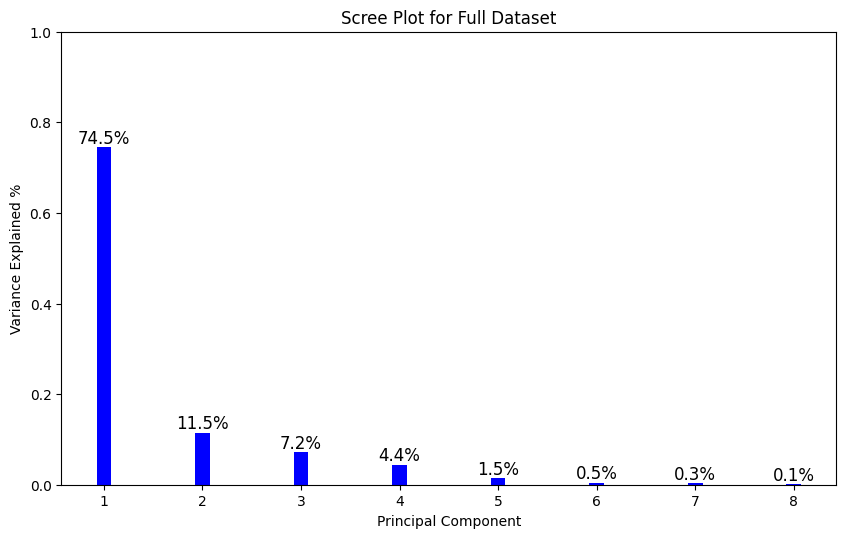

In [9]:
var = pca.explained_variance_ratio_
plt.figure(figsize=(10,6), dpi=100)
plot = plt.subplot(111)
plot.bar(['1','2','3','4','5','6','7','8'],var, width = 0.15, color = ['blue'])
plt.ylim(0,1)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained %")
plt.title("Scree Plot for Full Dataset")
for bar in plot.patches:
    plot.annotate(format(bar.get_height()*100, '.1f') + str('%'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha= "center", va='bottom', size = 12)

In [10]:
#Linear Regression model with full data and 10 fold cross validation
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Training scores: [0.41243769 0.37845845 0.40686278 0.41480958 0.40131238 0.39680991
 0.36764806 0.39194053 0.35619388 0.33015081]
Mean squared error: 30619.370053418825
Coefficient of determination (R2): 0.3802788198432503
[1278.20694234  928.60685937  965.2068391  ... 1279.99271143 1165.41485322
  991.77433013]


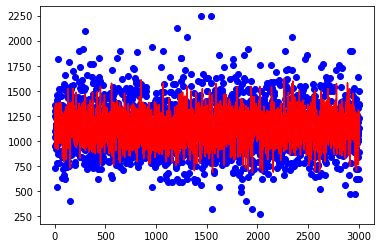

In [11]:
lg = LinearRegression()
scores = cross_val_score(lg, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
lg = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))

#Scatter plot of linear regression on all the data features
X_test=np.arange(0,len(X_test),1)
print(y_pred)
plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red")

In [12]:
#PCR model using the PCA transformed data with 3 components
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Mean squared error: 32495.597647479575
Coefficient of determination (R2): 0.38017295415522245
[ 977.83963652 1031.09246647 1186.01963538 ... 1150.84945354 1282.7172088
 1146.9078823 ]


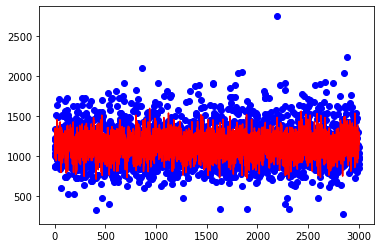

In [13]:
pcr = make_pipeline(StandardScaler(), PCA(n_components = 3), LinearRegression())
pcr.fit(X_train, y_train)

y_pred = pcr.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))
#Scatter plot of PCA linear regression on all the 3 components
X_test=np.arange(0,len(X_test),1)
print(y_pred)
plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red")

In [14]:
#Linear regression model with one alcohol column, one cig column, and the rest of the data columns
alcohol = ['alc_any_2008', 'alc_heavy_2008', 'alc_binge_2008']
cig = ['cig_total_2012', 'cig_daily_2012']

one_cig_one_alc_dfs = list()
for a in range(0,len(alcohol)):
    for c in range(0,len(cig)):
        a1 = alcohol[a]
        if a+1 == len(alcohol):
            a2 = alcohol[0]
        else: 
            a2 = alcohol[a+1]
        c= cig[c]
        data = data_features.drop(columns = ([a1,a2,c]))
        one_cig_one_alc_dfs.append(data)
        



In [60]:
#Linear Regression model with full data and 10 fold cross validation
for i in range(0,len(one_cig_one_alc_dfs)):
    X= one_cig_one_alc_dfs[i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    print(X.columns)
    
    lg = LinearRegression()
    scores = cross_val_score(lg, X_train, y_train, cv= 10)
    print("Training scores: " + str(scores))
    lg = lg.fit(X_train, y_train)
    y_pred = lg.predict(X_test)
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')

    

Index(['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012',
       'alc_binge_2008'],
      dtype='object')
Training scores: [0.40050493 0.34131993 0.31795308 0.39927472 0.3604962  0.3791062
 0.38693501 0.39454514 0.39901035 0.40785055]
Mean squared error: 32665.36750379813
Coefficient of determination (R2): 0.3895287787264522

Index(['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt_total_2012',
       'alc_binge_2008'],
      dtype='object')
Training scores: [0.36254647 0.33980108 0.37311557 0.40750188 0.39366214 0.37999144
 0.39500274 0.33962204 0.39187453 0.39043408]
Mean squared error: 34212.2421756245
Coefficient of determination (R2): 0.36831489177074794

Index(['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012',
       'alc_any_2008'],
      dtype='object')
Training scores: [0.38019823 0.30381678 0.37647136 0.35579845 0.42439174 0.37897312
 0.37675701 0.39854535 0.41310058 0.39467186]
Mean squared error: 31966.509602407583
Coeffic

Training scores: [0.06310549 0.06368777 0.05814963 0.08132476 0.06261462 0.05883137
 0.05485328 0.06718932 0.0766237  0.06232122]
Mean squared error: 49731.14813004413
Coefficient of determination (R2): 0.06108920877665647



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


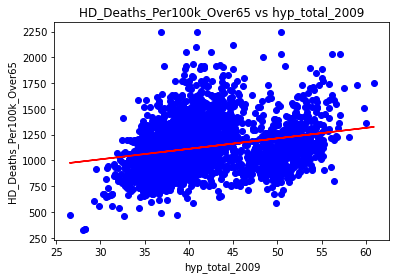

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.31311647 0.26347093 0.26693843 0.30876174 0.28399063 0.26729807
 0.26820089 0.22854496 0.35635295 0.27544068]
Mean squared error: 35669.39247047097
Coefficient of determination (R2): 0.2862109753401546



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


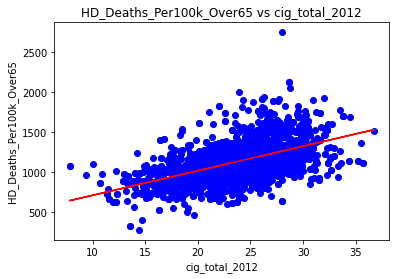

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.26275245 0.26092808 0.27689539 0.26438551 0.25286521 0.26617892
 0.25159125 0.23011038 0.29733521 0.24163266]
Mean squared error: 36463.246755484346
Coefficient of determination (R2): 0.28895773134123404



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


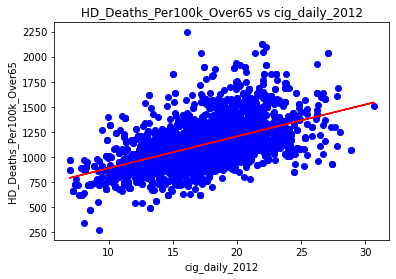

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.33240287 0.31369762 0.30743743 0.3381638  0.3288656  0.30569673
 0.31293896 0.3566806  0.31657687 0.32319158]
Mean squared error: 35480.3908727005
Coefficient of determination (R2): 0.3160558940586148



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


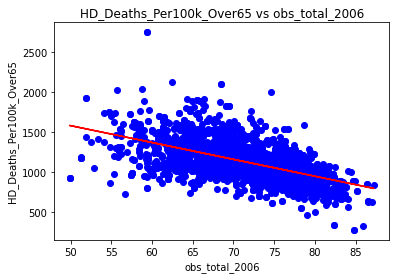

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.22497987 0.16119206 0.20820678 0.19380984 0.22577016 0.19626028
 0.20884304 0.19592404 0.21756444 0.21175241]
Mean squared error: 42586.28440525575
Coefficient of determination (R2): 0.20342362720599905



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


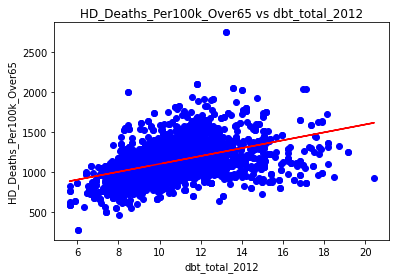

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.21139317 0.25646123 0.25840213 0.24486219 0.24781573 0.26227107
 0.24442507 0.25616003 0.22776224 0.24617643]
Mean squared error: 39704.16612992045
Coefficient of determination (R2): 0.25883922651354063



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


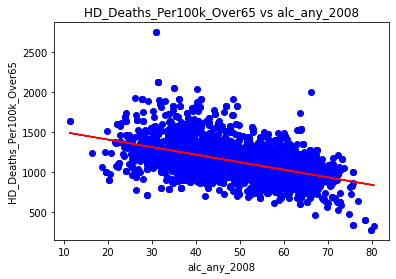

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.12087986 0.13815853 0.16697614 0.15006647 0.15624367 0.12665013
 0.11826749 0.13216141 0.12733383 0.13275967]
Mean squared error: 45816.771928444694
Coefficient of determination (R2): 0.15741017767668408



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


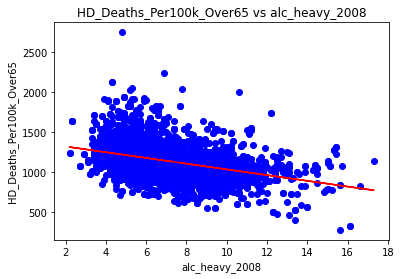

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.11611336 0.136495   0.12547348 0.15136271 0.1437447  0.14382953
 0.09423336 0.12114361 0.1472365  0.12663905]
Mean squared error: 46782.23118397403
Coefficient of determination (R2): 0.1183762661958414



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14208\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


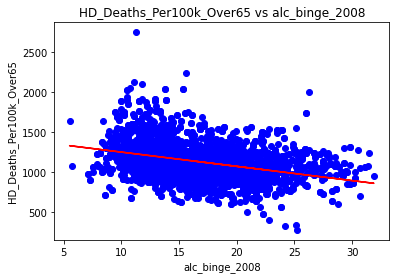

In [67]:
#Linear regression of each feature alone
n,m = data_features.shape
for i in range(0,m):
    
    X = data_features.iloc[:,i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    lg = LinearRegression()
    scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
    print("Training scores: " + str(scores))
  
    lg = lg.fit(X_train[:,np.newaxis], y_train)
    y_pred = lg.predict(X_test[:,np.newaxis])
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')
    
    #Scatter plot of PCA linear regression on all the 3 components
    plt.scatter(X_test,y_test, color="blue")
    plt.plot(X_test,y_pred, color = "red")
    plt.ylabel('HD_Deaths_Per100k_Over65')
    plt.xlabel(data_features.columns[i])
    plt.title('HD_Deaths_Per100k_Over65 vs ' + str(data_features.columns[i]))
    plt.show()